In [1]:
import torch 
import torch.nn as nn 
import pandas as pd 
import numpy as np 
import os
import time 
import sys
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import scanpy as sc
import matplotlib.pyplot as plt 
import model 
import torch.nn.functional as F

ModuleNotFoundError: No module named 'model'

In [19]:
count_embedding_num = 200
gene_embedding_num = 1000
d_model = 128
gene_padding_idx = 0
count_padding_idx = 101
n_head = 8
dim_ffn = 4*d_model
dropout = 0.1
layer_norm_eps =1e-5
batch_first = True
norm_first = False
num_layers = 4
norm = None
num_hiddens = 256

my_model = model.sc_pretrain(count_embedding_num,
                 gene_embedding_num,
                 d_model,
                 gene_padding_idx,
                 count_padding_idx,
                 n_head,
                 dim_ffn,
                 dropout,
                 layer_norm_eps,
                 batch_first,
                 norm_first,
                 num_layers,
                 norm,
                 num_hiddens)

In [20]:
gene_id = torch.randint(low = 0, high = 800,size = (4,16))
count_id = torch.randint(low=0, high=100, size = (4,16))


size = (4,16)
random_float_tensor = torch.rand(size)
bernoulli_tensor = torch.bernoulli(random_float_tensor)
boolean_tensor = bernoulli_tensor.bool()
mask = boolean_tensor 

size = (4,16)
random_float_tensor = torch.rand(size)
bernoulli_tensor = torch.bernoulli(random_float_tensor)
boolean_tensor = bernoulli_tensor.bool()
pred_positions = boolean_tensor

In [21]:
cell_embed, gene_pred = my_model(gene_id, count_id, mask, pred_positions[:,1:])
print(cell_embed.shape)
print(gene_pred.shape)

torch.Size([4, 256])
torch.Size([29, 200])


In [27]:
embed = model.embedding_layer(gene_id, count_id)
print(embed.shape)
embed = model.sc_encoder(embed, mask)
print(embed.shape)

torch.Size([4, 16, 128])
torch.Size([4, 16, 128])


In [28]:
cell_embed = embed[:,0,:]
print(cell_embed.shape)
cell_embed = model.cell_encoder(cell_embed)
print(cell_embed.shape)

torch.Size([4, 128])
torch.Size([4, 256])


In [30]:
embed[pred_positions,:].shape

torch.Size([24, 128])

In [10]:
gene_pred = model.mask_gp(embed,pred_positions)

IndexError: The shape of the mask [64] at index 0 does not match the shape of the indexed tensor [4, 16, 128] at index 1

In [11]:
num_pred_positions = pred_positions.shape[1]
pred_positions = pred_positions.reshape(-1)

print(num_pred_positions)
batch_size = embed.shape[0]
batch_idx = torch.arange(0, batch_size) 
print(batch_idx)

16
tensor([0, 1, 2, 3])


In [12]:
batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
batch_idx

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [16]:
embed.shape

torch.Size([4, 16, 128])

In [20]:
batch_idx

torch.Size([64])

In [22]:
pred_positions.shape

torch.Size([64])

In [23]:
embed.reshape(64,).shape

torch.Size([8192])

In [18]:
masked_x = embed[batch_idx, pred_positions]

IndexError: The shape of the mask [64] at index 0 does not match the shape of the indexed tensor [4, 16, 128] at index 1

In [ ]:
num_pred_positions = pred_positions.shape[1]
pred_positions = pred_positions.reshape(-1)

batch_size = embed.shape[0]
batch_idx = torch.arange(0, batch_size) 

batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
masked_x = embed[batch_idx, pred_positions]
masked_x = masked_x.reshape([batch_size, num_pred_positions, -1])
mgp = self.mlp(masked_x)

## 基本框架

1. input embedding:
   - gene embedding + count value embedding  
   - cls + gene embedding + pad

2. model structure:
   - embedding layer
   - transformer layer * N
   - output layer: value classification + cell constrastive learning 

3. dataloader: 
   - input: a batch of gene expression, gene symbol 
   - output: (sampled gene count id vec, sampled gene id) + constrastive batch

In [12]:
%%time

scdata = sc.read_10x_mtx(r"D:\sly_data\notebook\data\MHM", cache=True)
scdata
#gene_name = [f'gene_{i}' for i in range(1000)]
#cell_id = [f'cell_{i}' for i in range(200)]
#gene_exp = np.random.randint(0,10,size = (200,1000))

d:\Anaconda\envs\scvi\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


CPU times: total: 1.23 s
Wall time: 1.27 s


AnnData object with n_obs × n_vars = 8572 × 32285
    var: 'gene_ids', 'feature_types'

In [13]:
sc.pp.filter_cells(scdata, min_genes = 200)
sc.pp.filter_genes(scdata, min_cells = 10)
sc.pp.calculate_qc_metrics(scdata, inplace=True )
print(scdata.shape)
scdata.obs.head()

(8455, 19104)


,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACAGCCAAGTCGCT-1,4289,4283,8.362642,15397.0,9.641993,24.556732,32.980451,42.326427,56.679873
AAACAGCCAATAACGA-1,436,436,6.079933,584.0,6.371612,30.650685,42.465753,59.589041,100.000000
AAACAGCCACTAAATC-1,3065,3063,8.027477,8180.0,9.009570,23.924205,32.469438,42.078240,57.347188
AAACAGCCATCAGCAC-1,2000,1999,7.600902,4241.0,8.352790,25.795803,33.506249,43.739684,60.811129
AAACAGCCATGAAATG-1,389,389,5.966147,564.0,6.336826,36.170213,48.758865,66.489362,100.000000


In [24]:
def cell_process(gene_exp, gene_ids, cell_id, meta_info):
    # process cell info into a cell_dic
    # gene_exp: np.array, dtype = int, gene_counts
    # gene_ids: np.array, dtype = object,  gene_id 'ENSMUSG00000051951'
    # cell_id: int, the id of this cell_dic
    # meta_info: a dic, must record the ori dataset and ori cell idx

    cell_dic = {}
    
    cell_dic['cell_id'] = cell_id
    pos_id = (gene_exp > 0)
    cell_dic['pos_gene_ids'] = gene_ids[pos_id]
    cell_dic['pos_gene_exp'] = gene_exp[pos_id] 

    cell_dic['neg_gene_ids'] = gene_ids[~pos_id]

    cell_dic['pos_gene_num'] = cell_dic['pos_gene_ids'].shape[0]
    cell_dic['umi_counts'] = gene_exp.sum()
    cell_dic['meta_info'] = meta_info 
    return cell_dic

In [28]:
np.array(scdata[i,:].X.todense())

array([[21.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [31]:
from tqdm import tqdm 
import pyarrow.parquet as pq
import pyarrow as pa

gene_ids = scdata.var.index.values 
samples = []

for i in tqdm(range(scdata.shape[0])):
    res = cell_process(gene_exp= np.array(scdata[i,:].X.todense()).reshape(-1), 
                            gene_ids = gene_ids,
                            cell_id = i,
                            meta_info = {'cell_barcode': scdata.obs.index.values[i],
                                            'dataset': 'mhm'})

    samples.append(res)

df = pd.DataFrame(samples)

output_file = 'hm_data.parquet'

# 将DataFrame转换为Table并写入Parquet文件
table = pa.Table.from_pandas(df)
pq.write_table(table, output_file)

100%|██████████| 8455/8455 [01:54<00:00, 74.01it/s]


In [ ]:
class tokenizer():
    def __init__(self, gene2id_dic):
        self.gene2id_dic = gene2id_dic 

    def encode(gene_ids):
        # transform gene to int id 
        res = []
        for gene in gene_ids:
            if gene in gene2id_dic:
                res.append(gene2id_dic[gene])
            else:
                res.append(gene2id_dic['<unk>'])
        return res 

In [178]:
model = nn.MultiheadAttention(embed_dim = 16, num_heads = 4, batch_first = True)
query = torch.randn(size = (2,10,16))
key  = torch.randn(size = (2,10,16))
value  = torch.randn(size = (2,10,16))
key_padding_mask = torch.tensor([[True, False, False, False, True, False, False, False, False, False],
                                 [False, False, False, False, True, True, False, False, False, False]])

attn_output, attn_output_weights = model(query, key, value, key_padding_mask)

In [182]:
import torch.nn.functional as F
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = F.cosine_similarity(input1, input2)
print(output.shape)

torch.Size([100])


In [185]:
query[:,0,:].shape

torch.Size([2, 16])

In [179]:
print(attn_output.shape)

torch.Size([2, 10, 16])


In [181]:
attn_output[key_padding_mask].shape

torch.Size([4, 16])

In [177]:
(value[0][:,:4] @ model.in_proj_weight[32:,:4].T).shape

torch.Size([10, 16])

In [176]:
tmp = value[0][:,:4] @ model.in_proj_weight[32:,:4].T + model.in_proj_bias[32:]
print(tmp.shape)
tmp = attn_output_weights[0] @ tmp
res = model.out_proj(tmp)
res

torch.Size([10, 16])


tensor([[-0.0063, -0.0389,  0.0047, -0.0165, -0.0058,  0.0184,  0.0333,  0.0343,
          0.0181,  0.0016, -0.0479,  0.0440, -0.0387, -0.0085,  0.0437,  0.0245],
        [-0.0030, -0.0059,  0.0632,  0.0081, -0.0323,  0.0139, -0.0011,  0.0271,
          0.0061,  0.0051, -0.0858,  0.0239, -0.0082,  0.0179,  0.0362,  0.0557],
        [ 0.0112, -0.0176,  0.0719, -0.0235, -0.0358,  0.0141,  0.0081,  0.0372,
         -0.0299,  0.0463, -0.0646,  0.0749, -0.0132, -0.0115,  0.0674,  0.0733],
        [-0.0135, -0.0352,  0.0190, -0.0022, -0.0147,  0.0243,  0.0295,  0.0373,
          0.0335, -0.0122, -0.0814,  0.0320, -0.0414,  0.0065,  0.0412,  0.0327],
        [ 0.0082, -0.0351,  0.0130, -0.0173,  0.0016, -0.0053,  0.0219,  0.0321,
          0.0016,  0.0090, -0.0190,  0.0362, -0.0052, -0.0004,  0.0444,  0.0308],
        [ 0.0078, -0.0226,  0.0610, -0.0193, -0.0296,  0.0129,  0.0124,  0.0381,
         -0.0172,  0.0338, -0.0651,  0.0650, -0.0153, -0.0061,  0.0630,  0.0657],
        [ 0.0083, -0.0

In [156]:
# 查看模型的所有参数及其名称
for name, param in model.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}")

Name: in_proj_weight, Shape: torch.Size([48, 16])
Name: in_proj_bias, Shape: torch.Size([48])
Name: out_proj.weight, Shape: torch.Size([16, 16])
Name: out_proj.bias, Shape: torch.Size([16])


In [152]:
## model.out_proj(x) = x @ model.out_proj.weight.T + model.out_proj.bias
## multihead_attention(single head): attn_output = tmp = value[0] @ model.in_proj_weight[32:].T + model.in_proj_bias[32:]
# tmp = attn_output_weights[0] @ tmp 
# model.out_proj(tmp) 

In [153]:
tmp @ model.out_proj.weight.T + model.out_proj.bias  == model.out_proj(tmp)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,

In [160]:
tmp = value[0] @ model.in_proj_weight[32:].T + model.in_proj_bias[32:]
tmp = attn_output_weights[0] @ tmp
res = model.out_proj(tmp)

attn_output[0] == res

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
    

In [105]:
attn_output[0]

tensor([[-0.1264,  0.1540,  0.0752,  0.0133, -0.1145,  0.0009,  0.0770, -0.2103,
          0.0338,  0.0232,  0.2429,  0.0411, -0.0689,  0.1302, -0.0743, -0.1119],
        [-0.0771,  0.2807,  0.1136, -0.0320, -0.1886,  0.0505,  0.0859, -0.3231,
          0.1078,  0.1941,  0.3086,  0.0491, -0.1624,  0.2082, -0.0921, -0.0742],
        [-0.2141,  0.0450,  0.0574,  0.1150, -0.0922, -0.0728, -0.0094, -0.0021,
         -0.0428, -0.1372,  0.2298,  0.0083, -0.0843, -0.0446,  0.0044, -0.2458],
        [-0.2566,  0.2175,  0.0122,  0.0584, -0.2062,  0.0403, -0.0108, -0.1681,
         -0.1137, -0.0635,  0.2441,  0.0200, -0.1044,  0.1229, -0.1079, -0.3916],
        [-0.1905,  0.1851,  0.0504,  0.0442, -0.1620,  0.0132,  0.0010, -0.1454,
         -0.0389, -0.0038,  0.2476,  0.0259, -0.1254,  0.0972, -0.0704, -0.2629],
        [-0.1851,  0.2030,  0.0811,  0.0425, -0.1680,  0.0440,  0.0056, -0.2406,
          0.0075,  0.0228,  0.3357,  0.0552, -0.1869,  0.1208, -0.0845, -0.2337],
        [-0.1844,  0.0

In [87]:
(attn_output_weights[0] @  value[0] )

tensor([[-0.6152,  0.5296,  0.5794, -0.2073, -0.1746,  0.0762,  0.0607, -0.2378,
          0.0372,  0.0304,  0.1250, -0.3856, -1.0762, -0.4057, -0.0326,  1.1652],
        [-0.2357,  0.1701,  0.5856, -0.3487, -0.2280,  0.2612,  0.2355, -0.3257,
         -0.0621,  0.3006,  0.0531, -0.0953, -0.8221, -0.4019,  0.1040,  1.1983],
        [-0.1173,  0.4102,  0.6795, -0.3494, -0.4370,  0.0664,  0.0577, -0.7595,
         -0.2141,  0.0751,  0.1539,  0.0344, -0.2803, -0.4642,  0.5667,  1.2202],
        [-0.3127,  0.2461,  0.6038, -0.2982, -0.1593,  0.0750,  0.2022, -0.2687,
         -0.0446,  0.2117,  0.0863, -0.0602, -0.8036, -0.3319,  0.0883,  1.1219],
        [-0.6706,  0.3565,  0.5449, -0.3397, -0.0542,  0.1654,  0.0988, -0.0202,
         -0.0975,  0.0546,  0.0682, -0.4595, -1.4845, -0.3918, -0.0900,  1.2696],
        [-0.2410,  0.3667,  0.7105, -0.2355, -0.1535, -0.0221,  0.1234, -0.3839,
          0.0016,  0.2261,  0.0247,  0.0423, -0.5179, -0.2635,  0.1390,  1.1171],
        [-0.3962,  0.3

In [47]:
attn_output_weights[0]

tensor([[0.0000, 0.1245, 0.1893, 0.1339, 0.0000, 0.1311, 0.1024, 0.1126, 0.0800,
         0.1262],
        [0.0000, 0.1294, 0.1626, 0.1115, 0.0000, 0.1438, 0.1156, 0.1188, 0.1004,
         0.1178],
        [0.0000, 0.1020, 0.0836, 0.1008, 0.0000, 0.1666, 0.1823, 0.0930, 0.1546,
         0.1171],
        [0.0000, 0.1554, 0.1740, 0.1611, 0.0000, 0.1153, 0.1005, 0.0996, 0.0816,
         0.1125],
        [0.0000, 0.1494, 0.1753, 0.1857, 0.0000, 0.1272, 0.0806, 0.1164, 0.0642,
         0.1013],
        [0.0000, 0.0814, 0.0742, 0.0818, 0.0000, 0.1024, 0.1317, 0.0982, 0.3099,
         0.1204],
        [0.0000, 0.1060, 0.1540, 0.0752, 0.0000, 0.1462, 0.1164, 0.0926, 0.1876,
         0.1219],
        [0.0000, 0.1152, 0.1091, 0.1045, 0.0000, 0.1561, 0.1519, 0.1229, 0.1468,
         0.0936],
        [0.0000, 0.1301, 0.1687, 0.1461, 0.0000, 0.1594, 0.1088, 0.0871, 0.0858,
         0.1140],
        [0.0000, 0.1153, 0.1259, 0.1960, 0.0000, 0.0806, 0.1052, 0.1573, 0.0985,
         0.1211]], grad_fn=<

In [78]:
import torch
import torch.nn as nn

model = nn.MultiheadAttention(embed_dim=16, num_heads=1, batch_first=True)
query = torch.randn(size=(2, 10, 16))
key = torch.randn(size=(2, 10, 16))
value = torch.randn(size=(2, 10, 16))
key_padding_mask = torch.tensor([
    [True, False, False, False, True, False, False, False, False, False],
    [False, False, False, False, True, True, False, False, False, False]
])

attn_output, attn_output_weights = model(query, key, value, key_padding_mask=key_padding_mask)

# 计算 attn_output_weights 与 value 的乘积
# attn_output_weights 的形状为 (batch_size, seq_len, seq_len)
# value 的形状为 (batch_size, seq_len, embed_dim)
# 我们需要进行批量矩阵乘法
attn_output_reconstructed = torch.bmm(attn_output_weights, value)

# 比较 attn_output 与 attn_output_reconstructed
print("Original attn_output:", attn_output)
print("Reconstructed attn_output:", attn_output_reconstructed)

# 检查两者是否相同
print("Are they equal?", torch.allclose(attn_output, attn_output_reconstructed, atol=1e-6))

Original attn_output: tensor([[[ 7.8775e-02, -1.4985e-01,  1.2982e-01, -1.1621e-01,  4.3176e-02,
          -5.9832e-02, -1.1051e-02, -4.8251e-02,  3.6437e-02, -7.8387e-03,
          -1.9143e-01, -4.4591e-02, -8.2111e-02,  3.2287e-02,  2.8178e-03,
          -1.2040e-01],
         [ 3.5377e-02, -1.2024e-01,  2.7264e-01, -1.7746e-01,  1.4927e-02,
          -7.7830e-02, -1.5373e-01, -1.0556e-01,  8.2224e-02,  8.1203e-02,
          -3.2284e-01, -4.7549e-02, -2.1195e-01,  9.8409e-02, -3.3826e-02,
          -1.0516e-01],
         [ 9.8109e-02, -1.5123e-01,  1.5880e-01, -1.6578e-01,  4.4249e-02,
          -8.2077e-02, -7.3562e-02, -7.8680e-02,  1.3971e-01,  6.4754e-02,
          -2.6878e-01, -1.0598e-02, -1.8274e-01,  3.8592e-02, -2.1477e-02,
          -5.8919e-02],
         [ 7.2085e-02, -1.5613e-01,  2.2915e-01, -1.4723e-01,  2.5716e-02,
          -4.3876e-02, -7.7761e-02, -8.8087e-02,  6.8243e-02,  3.7503e-02,
          -2.5303e-01, -3.4986e-02, -1.5304e-01,  7.7125e-02, -2.2803e-02,
      

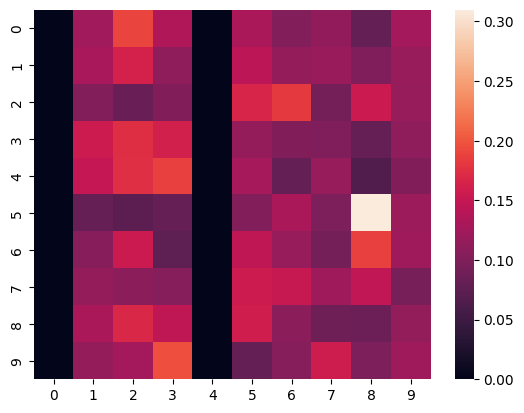

In [45]:
import seaborn as sns 

sns.heatmap(attn_output_weights[0].detach().numpy())
plt.show()

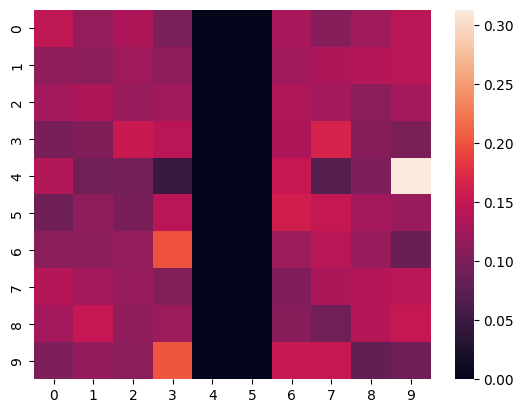

In [46]:
sns.heatmap(attn_output_weights[1].detach().numpy())
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class my_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        """
        初始化数据集。
        
        :param file_path: CSV 文件路径
        :param transform: 可选的转换函数
        """
        self.file_path = file_path
        self.transform = transform
        # 读取CSV文件的第一行来获取列数（即特征数量）
        with open(file_path, 'r') as f:
            self.num_features = len(f.readline().strip().split(',')) - 1  # 减1是因为第一列可能是标签
        # 获取CSV文件的行数，用于计算数据集长度
        self.length = sum(1 for line in open(file_path)) - 1  # 减1是因为第一行是表头
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        """
        :param index: 样本的索引
        :return: 样本数据
        """
        # 从文件中读取指定索引的行
        skip_rows = list(range(1, index + 1)) + list(range(index + 2, self.length + 1))
        df = pd.read_csv(self.file_path, header=None, skiprows=skip_rows, usecols=range(1, self.num_features + 1))
        sample = df.values.flatten().astype(np.float32)  # 将数据转换为float32类型
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

# 示例：定义一个转换函数
def transform_fn(sample):
    # 对样本执行任何必要的转换，例如归一化
    return sample / 255.0  # 假设原始数据在0-255之间

# 创建数据集实例
dataset = my_Dataset(file_path='path_to_your_large_csv_file.csv', transform=transform_fn)

# 创建DataLoader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# 使用DataLoader
for batch in data_loader:
    # 在这里处理你的批次数据，例如传递给模型进行训练
    print(batch.shape)

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch  
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

d:\Anaconda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt 

def tokenize(gene_exp, gene_name, gene2id_dic):
    # gene_exp: a single cell gene express vec
    # gene_name: corresponding gene name 
    # gene2id_dic: a dictionary, key is gene_id, value is a int id, eg gene2id_dic['Slc1a2'] = 100

    gene_id = [gene2id_dic[_] for _ in gene_name] #gene_name.map(gene2id_dic) 
    
    sorted_id = np.argsort(-gene_exp, stable=True)
    ranks = np.empty_like(sorted_id)
    ranks[sorted_id] = np.arange(len(gene_exp))
    return gene_id, ranks

In [2]:
np.__version__

'1.26.2'

In [12]:
gene2id_dic = {}
count = 0
for gene in gene_name:
    gene2id_dic[gene] = count
    count += 1 

tokenize(gene_exp[0,:10], gene_name[:10], gene2id_dic)

TypeError: argsort() got an unexpected keyword argument 'stable'